In [22]:
from __future__ import division
import numpy as np
import random as rnd

gam = 0.1
dt = 0.01
nsteps = 20000
nsteps_relax = 0
nrun = 400
window_size = 10
thres = 0.75

#RUNGE–KUTTA ESTOCÁSTICO oscilador chiral subamortiguado.

def integrate_motion(nr, n, dt, gamma):

    sqrt_dt = np.sqrt(dt)
    rnd.seed()
    vx = rnd.gauss(0., 1.) / np.sqrt(2*gamma)
    vy = rnd.gauss(0., 1.) / np.sqrt(2*gamma)

    def f_vx(vx, vy):
        return -gamma*vx - vy

    def f_vy(vx, vy):
        return -gamma*vy + vx

# relajación 
    for _ in range(nr):
        k1_vx = dt * f_vx(vx, vy)
        k1_vy = dt * f_vy(vx, vy)

        k2_vx = dt * f_vx(vx + 0.5*k1_vx, vy + 0.5*k1_vy)
        k2_vy = dt * f_vy(vx + 0.5*k1_vx, vy + 0.5*k1_vy)

        k3_vx = dt * f_vx(vx + 0.5*k2_vx, vy + 0.5*k2_vy)
        k3_vy = dt * f_vy(vx + 0.5*k2_vx, vy + 0.5*k2_vy)

        k4_vx = dt * f_vx(vx + k3_vx, vy + k3_vy)
        k4_vy = dt * f_vy(vx + k3_vx, vy + k3_vy)

        vx += (k1_vx + 2*k2_vx + 2*k3_vx + k4_vx)/6 + sqrt_dt*rnd.gauss(0.,1)
        vy += (k1_vy + 2*k2_vy + 2*k3_vy + k4_vy)/6 + sqrt_dt*rnd.gauss(0.,1)

# estado estable
    vx_arr = np.zeros(n)
    vy_arr = np.zeros(n)
    for i in range(n):
        k1_vx = dt * f_vx(vx, vy)
        k1_vy = dt * f_vy(vx, vy)

        k2_vx = dt * f_vx(vx + 0.5*k1_vx, vy + 0.5*k1_vy)
        k2_vy = dt * f_vy(vx + 0.5*k1_vx, vy + 0.5*k1_vy)

        k3_vx = dt * f_vx(vx + 0.5*k2_vx, vy + 0.5*k2_vy)
        k3_vy = dt * f_vy(vx + 0.5*k2_vx, vy + 0.5*k2_vy)

        k4_vx = dt * f_vx(vx + k3_vx, vy + k3_vy)
        k4_vy = dt * f_vy(vx + k3_vx, vy + k3_vy)

        vx += (k1_vx + 2*k2_vx + 2*k3_vx + k4_vx)/6 + sqrt_dt*rnd.gauss(0.,1)
        vy += (k1_vy + 2*k2_vy + 2*k3_vy + k4_vy)/6 + sqrt_dt*rnd.gauss(0.,1)

        vx_arr[i] = vx
        vy_arr[i] = vy

    vnorm2_arr = vx_arr**2 + vy_arr**2
    vnorm_arr = np.sqrt(vnorm2_arr)
    vorix_arr = vx_arr / vnorm_arr
    voriy_arr = vy_arr / vnorm_arr

    return vx_arr, vy_arr, vnorm2_arr, vorix_arr, voriy_arr

def compute_theta(dt, vx, vy):
    theta_corr = np.zeros(len(vx))
    theta_corr[0] = np.arctan2(vy[0], vx[0])
    nber_loop = 0
    spin = []
    t_spin = []
    for i in range(1, len(vx)):
        theta_raw = np.arctan2(vy[i], vx[i])
        trials = [theta_raw + nber_loop*2*np.pi,
                  theta_raw + (nber_loop+1)*2*np.pi,
                  theta_raw + (nber_loop-1)*2*np.pi]
        k = np.argmin(np.abs(trials - theta_corr[i-1]))
        theta_corr[i] = trials[k]
        if k==1: nber_loop += 1
        if k==2: nber_loop -= 1
        eps = 1. if theta_corr[i] > theta_corr[i-1] else -1.
        if i<2:
            spin.append(eps)
            t_spin.append(0)
        elif eps * spin[-1] < 0.:
            spin.append(eps)
            t_spin.append(i-1)
    return theta_corr, spin, t_spin

# INTEGRACIÓN 

vx_arr_all = np.zeros((nsteps, nrun))
vy_arr_all = np.zeros((nsteps, nrun))
spectrum_all = np.zeros((nsteps, nrun))
spectrum_ori_all = np.zeros((nsteps, nrun))
spectrum_norm2_all = np.zeros((nsteps, nrun))
time = np.arange(nsteps)*dt

for j in range(nrun):
    vx_arr, vy_arr, vnorm2_arr, vorix_arr, voriy_arr = integrate_motion(nsteps_relax, nsteps, dt, gam)
    vx_arr_all[:,j] = vx_arr
    vy_arr_all[:,j] = vy_arr
    spectrum_all[:,j] = np.abs(np.fft.fft(vx_arr))**2 + np.abs(np.fft.fft(vy_arr))**2
    spectrum_ori_all[:,j] = np.abs(np.fft.fft(vorix_arr))**2 + np.abs(np.fft.fft(voriy_arr))**2
    spectrum_norm2_all[:,j] = np.abs(np.fft.fft(vnorm2_arr))**2

# Promedios y errores tipo jackknife 
spectrum = np.mean(spectrum_all, axis=1)/nsteps
spectrum_ori = np.mean(spectrum_ori_all, axis=1)/nsteps
spectrum_norm2 = np.mean(spectrum_norm2_all, axis=1)/nsteps

u_spectrum = np.sqrt(np.sum((spectrum_all - spectrum[:,None]*nsteps)**2, axis=1))/nsteps
u_spectrum_ori = np.sqrt(np.sum((spectrum_ori_all - spectrum_ori[:,None]*nsteps)**2, axis=1))/nsteps
u_spectrum_norm2 = np.sqrt(np.sum((spectrum_norm2_all - spectrum_norm2[:,None]*nsteps)**2, axis=1))/nsteps

# --- Ordenar frecuencias ---
freq = np.fft.fftfreq(nsteps, dt)
idx = np.argsort(freq)
freq_sorted = freq[idx]
spectrum = spectrum[idx]
spectrum_ori = spectrum_ori[idx]
spectrum_norm2 = spectrum_norm2[idx]
u_spectrum = u_spectrum[idx]
u_spectrum_ori = u_spectrum_ori[idx]
u_spectrum_norm2 = u_spectrum_norm2[idx]

# Ventana espectral
spectrum_smooth = np.convolve(spectrum, np.ones(2*window_size)/ (2*window_size), mode='same')
spectrum_max = np.max(spectrum_smooth)
spectrum_min = spectrum_smooth[np.argmin(np.abs(freq_sorted))]
window_arr = np.zeros(nsteps)
window_arr[(spectrum_max - spectrum_smooth) < (1-thres)*(spectrum_max - spectrum_min)] = 1
fmin = np.min(np.abs(freq[window_arr>0]))
fmax = np.max(np.abs(freq[window_arr>0]))
window_arr[(np.abs(freq) > fmin) & (np.abs(freq) < fmax)] = 1

spectrum_smooth = np.zeros(nsteps)
for i in range(nsteps):
    if i > window_size and i < nsteps - window_size:
        spectrum_smooth[i] = np.mean(spectrum[i - window_size: i + window_size])
    else:
        spectrum_smooth[i] = spectrum[i]
spectrum_max = np.amax(spectrum_smooth)
spectrum_min = spectrum_smooth[np.argmin(np.absolute(freq_sorted))]
window_arr = np.zeros(nsteps)
for i in range(nsteps):
    if spectrum_max - spectrum_smooth[i] < ( 1. - thres ) * ( spectrum_max - spectrum_min ):
        j = np.argmin(np.absolute(freq - freq_sorted[i]))
        window_arr[j] = 1.
fmin = np.amin(np.absolute(freq[window_arr > 0.]))
fmax = np.amax(np.absolute(freq[window_arr > 0.]))
for i in range(nsteps):
    if np.absolute(freq[i]) > fmin and np.absolute(freq[i]) < fmax:
        window_arr[i] = 1.
nchiral = np.zeros(nrun, dtype = int)
spin_tot = np.zeros((nsteps, nrun))
t_spin_tot = np.zeros((nsteps, nrun))
for j in range(nrun):
    vx_smooth = np.real(np.fft.ifft(window_arr * np.fft.fft(vx_arr_all[:,j])))
    vy_smooth = np.real(np.fft.ifft(window_arr * np.fft.fft(vy_arr_all[:,j])))
    theta_corr, spin, t_spin = compute_theta(dt, vx_smooth, vy_smooth)
    nchiral[j] = len(spin)
    for i in range(nchiral[j]):
        spin_tot[i,j] = spin[i]
        t_spin_tot[i,j] = t_spin[i]
    t_spin_tot[nchiral[j],j] = nsteps

proba_plus = 0. # probabilidad spin positivo
proba_moins = 0. # probabilidad spin negativo
for j in range(nrun):
    for i in range(nchiral[j]):
        ns = t_spin_tot[i + 1,j] - t_spin_tot[i,j]
        if spin_tot[i,j] > 0.5:
            proba_plus += ns
        else:
            proba_moins += ns
sum_plus = proba_plus
sum_moins = proba_moins
proba_plus /= nrun
proba_moins /= nrun
proba_plus /= ( nsteps - 1 )
proba_moins /= ( nsteps - 1 )

u_proba_plus = 0. 
u_proba_moins = 0. 
for j in range(nrun):
    proba_plus_tmp = sum_plus
    proba_moins_tmp = sum_moins
    for i in range(nchiral[j]):
        ns = t_spin_tot[i + 1,j] - t_spin_tot[i,j]
        if spin_tot[i,j] > 0.5:
            proba_plus_tmp -= ns
        else:
            proba_moins_tmp -= ns
    ntmp = ( nsteps - 1 ) * ( nrun - 1 )
    proba_plus_tmp /= ntmp
    proba_moins_tmp /= ntmp
    u_proba_plus += ( proba_plus_tmp - proba_plus ) ** 2
    u_proba_moins += ( proba_moins_tmp - proba_moins ) ** 2
u_proba_plus **= 0.5
u_proba_moins **= 0.5
# --- Guardar resultados ---
np.savetxt(f'Chispectrum_ori_gamma{gam:.1f}.txt', np.vstack((2*np.pi*freq_sorted, spectrum_ori, u_spectrum_ori)).T, header='w S^v u(S^v)')
np.savetxt(f'Chispectrum_norm2_gamma{gam:.1f}.txt', np.vstack((2*np.pi*freq_sorted, spectrum_norm2, u_spectrum_norm2)).T, header='w Sv2 u(Sv2)')
np.savetxt(f'Chispectrum_gamma{gam:.1f}.txt', np.vstack((2*np.pi*freq_sorted, spectrum, u_spectrum)).T, header='w Sv u(Sv)')
np.savetxt(f'Chiproba_spin_gamma{gam:.1f}.txt', np.vstack(([-1,1], [proba_moins, proba_plus], [0,0])).T, header='eps P(eps) u(P(eps))')


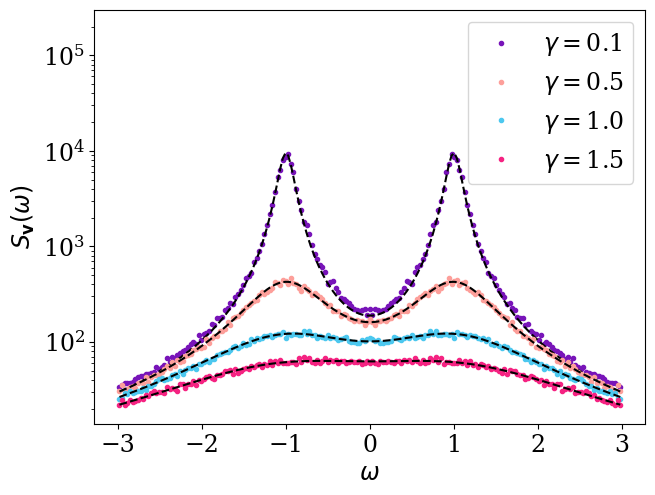

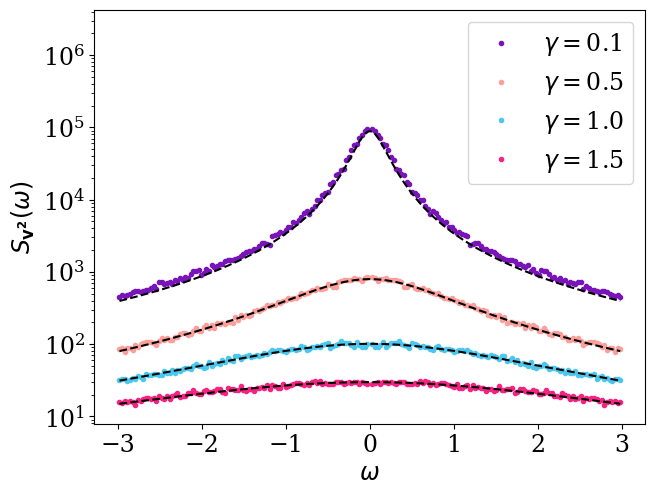

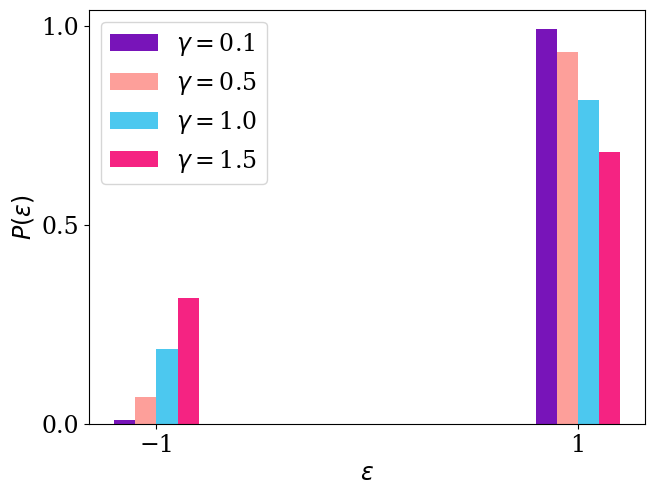

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = False
params = {'text.usetex' : False,
          'font.size' : 17,
          'font.family' : 'serif',
          }
plt.rcParams.update(params)
color_show = [ '#7814B9', '#FD9F9A', '#4CC8EF', '#F52382' ] # list of colors for the different curves


gamma_show = [ 0.1, 0.5, 1., 1.5 ] # values of the friction coefficient to display


# PLOT THE VELOCTY SPECTRUM 

def spectrum_vel(x, gam, a):

    return 4. * a * ( 1. + gam * gam + x ** 2 ) * ( np.sqrt(gam * gam + 1.) - 1. ) / ( gam * gam + ( x - 1. ) ** 2 ) / ( gam * gam + ( x + 1. ) ** 2 ) 

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for gam in gamma_show:
    data = np.genfromtxt('Chispectrum_gamma{0:.1f}.txt'.format(gam))
    omega = data[:,0]
    spectrum = data[:,1]
    u_spectrum = data[:,2]
    spectrum = spectrum[np.absolute(omega) < 3.]
    u_spectrum = u_spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    ax.plot(omega, spectrum, marker = '.', linestyle = '', c = color_show[k], label = r'$\gamma=${0:.1f}'.format(gam))
    ax.fill_between(omega, spectrum - u_spectrum, spectrum + u_spectrum, color = color_show[k], alpha = 0) 
    popt, pcov = curve_fit(lambda x, a: spectrum_vel(x, gam, a), omega, spectrum, np.amax(spectrum)) # find the best value of the amplitude to fit the numerical solution and the analytic solution
    ax.plot(omega, spectrum_vel(omega, gam, popt[0]), '--k')
    k += 1   
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v}(\omega)$')
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()


# PLOT THE SPECTRUM OF THE MAGNITUDE OF THE VELOCITY

def spectrum_vel2(x, gam, a):

    return 4. * a / gam / ( 4. * gam * gam + x * x )

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for gam in gamma_show:
    data = np.genfromtxt('Chispectrum_norm2_gamma{0:.1f}.txt'.format(gam))
    omega = data[:,0]
    spectrum = data[:,1]
    u_spectrum = data[:,2]
    spectrum[np.argmin(np.absolute(omega))] = 0. # avoid overflow at zero angular frequency (the value of the spectrum is equal to the variance of v)
    spectrum = spectrum[np.absolute(omega) < 3.]
    u_spectrum = u_spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    ax.plot(omega[omega > 1e-5], spectrum[omega > 1e-5], marker = '.', linestyle = '', c = color_show[k], label = r'$\gamma=${0:.1f}'.format(gam))
    ax.plot(omega[omega < - 1e-5], spectrum[omega < - 1e-5], marker = '.', linestyle = '', c = color_show[k])
    ax.fill_between(omega[omega > 1e-5], spectrum[omega > 1e-5] - u_spectrum[omega > 1e-5], spectrum[omega > 1e-5] + u_spectrum[omega > 1e-5], color = color_show[k], alpha = 0)
    ax.fill_between(omega[omega < - 1e-5], spectrum[omega < - 1e-5] - u_spectrum[omega < - 1e-5], spectrum[omega < - 1e-5] + u_spectrum[omega < - 1e-5], color = color_show[k], alpha = 0)  
    popt, pcov = curve_fit(lambda x, a: spectrum_vel2(x, gam, a), omega, spectrum, np.amax(spectrum)) # find the best value of the amplitude to fit the numerical solution and the analytic solution
    ax.plot(omega, spectrum_vel2(omega, gam, popt[0]), '--k')
    k += 1   
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v^2}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

# PLOT THE SPIN HISTOGRAM 

x = np.array([-1, 1])
bar_width = 0.1 # width of the histogram bars
f, ax = plt.subplots()
k = 0
for gam in gamma_show:
    data = np.genfromtxt('Chiproba_spin_gamma{0:.1f}.txt'.format(gam))
    proba = data[:,1]
    u_proba = data[:,2]
    ax.bar(x + ( k - ( len(gamma_show) - 1. ) * 0.5 ) * bar_width, proba, yerr = u_proba, width = bar_width, color = color_show[k], label = r'$\gamma=${0:.1f}'.format(gam))
    k += 1
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$P(\epsilon)$')
ax.set_xticks([-1, 1])
ax.set_yticks([0, 0.5, 1])
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

